In [1]:
import copy
import time

from PIL import Image
import numpy as np
import tqdm

In [2]:
def open_convert_img(image_path):
    """Read and convert to gray-scale image
    """
    img = Image.open(image_path)
    img = np.array(img.convert("L"),dtype=np.float32)
    return img

def open_img(image_path):
    """Read and convert to gray-scale image
    """
    img = Image.open(image_path)
    img = np.array(img,dtype=np.float32)
    return img

def calculate_function_H(current_index, d, left_line, right_line, norm="L2"):
    """Args:
    current_index : int in [0,..,m]
    d: int in [0,...,maxD]
    left_line : 1-d array represneting a row from left image
    right_line : 1-d array represneting a row from right image(corresponde to left_line)
    norm : str defines norm either "L1" or "L2"
    Returns:
        diff : int16
    """
    if (current_index - d) < 0:
        return None
    else :
        diff = left_line[:,current_index] - right_line[:,current_index - d]
        if norm == "L1":
            return np.abs(diff)
        if norm == "L2":
            return np.sqrt((diff)**2)
        raise ValueError("Incorrect argument 'norm' in 'calculate_function_H'")

def calculate_f_step_0(set_D,image_left, image_right, n_columns):
    """Calculate f0 (due to seminar's notion)
    Args:
        set_D : ordered numpy array (e.g. [0,1,2,...,maxD])
        left_line : 1-d array represneting a row from left image
        right_line : 1-d array represneting a row from right image(corresponde to left_line)
    Returns:
        f0_list : list of f0(d) , d є set_D
        s_list :  list of lists
    """
    f0_array = np.ones((n_columns,1),dtype=np.float32)
    s0_array = np.ones((n_columns,1,1),dtype=np.float32)
    #s_list = list()
    for d in set_D:
        current_nodes = calculate_function_H(0,d, image_left, image_right,"L1")
        #print(current_nodes)
        if current_nodes is None:
            break
        f0_array = current_nodes.reshape(n_columns,1)
        s0_array[:,d,d] = 0
        #s_list.append([0])
    return f0_array, s0_array


def find_best_d_prev_for_d_next(index_next,d_next,set_D, n_columns, f_previous_array, image_left, image_right, verteces, alpha=50):
    """For a given d_next and step i, find fi(d_next) (due to seminar's notion)
    Args:
        index_next : int argument, respreseing an index of pixel
        d_next : int, d from set_D, which we're finding a minimum value of f to
        set_D : ordered numpy array (e.g. [0,1,2,...,maxD])
        f_previous_array : n_columns*set_D_previous
        left_line : 1-d array represneting a row from left image
        right_line : 1-d array represneting a row from right image(corresponde to left_line)
    Return:
        min_values : n_columns*1 
        min_argumnet : n_columns*1
    """ 
    min_matrix = np.zeros((n_columns, f_previous_array.shape[1]))
    #print("min_matrix.shape : ", min_matrix.shape)
    for d_previous in range(0,f_previous_array.shape[1]):
        next_values = f_previous_array[:,d_previous] + alpha*verteces[d_previous,d_next]
        min_matrix[:,d_previous] = next_values
    #print(min_matrix)
    #min_matrix = np.array(min_list)
    min_values = min_matrix.min(axis=1)
    #print("min_values.shape :", min_values.shape)
    min_arguments = min_matrix.argmin(axis=1)
    min_values = np.add(min_values,calculate_function_H(index_next, d_next, image_left, image_right,"L1"))
    #print("H :", calculate_function_H(index_next, d_next, image_left, image_right,"L2"))
    return min_values, min_arguments


def calculate_f_next(index_next, set_D, n_columns,s_previous_array, f_previous_array, image_left, image_right, verteces):
    """Using 'find_best_d_prev_for_d_next' , find fi(d) , for each d є set_D.
    Args:
        index_next : int argument, respreseing an index of pixel
        set_D : ordered numpy array (e.g. [0,1,2,...,maxD])
        f_previous_matrix : n_columns*len(set_D)<= 
        s_previous_array : n_columns*len(set_D)*450
        left_line : 1-d array represneting a row from left image
        right_line : 1-d array represneting a row from right image(corresponde to left_line)
    Return:
        f_next_list : list of f_next_list(d) , d є set_D
    """
    if f_previous_array.shape[1] == len(set_D):
        width = len(set_D)
    else :
        width = f_previous_array.shape[1] + 1

        
    f_next_array = np.zeros((n_columns,width), dtype= np.float32)
    width_s = s_previous_array.shape[2] + 1
    s_next_array = np.zeros((n_columns,width,width_s),dtype=np.uint8)
    #print("s_next_array ",s_next_array.shape)
    #print("s_previous_array ",s_previous_array.shape)
    #print("(calculate_f_next) f_next_array.shape : ", f_next_array.shape)
    
    #s_new_list = list()
    for d in range(0,width):
        next_values, previous_ds = find_best_d_prev_for_d_next(index_next, d, set_D, n_columns, f_previous_array, image_left, image_right, verteces)
        f_next_array[:,d] = next_values
        #print("s_next_array[:,d,:-1] : ", s_next_array[:,d,:-1].shape)
        #print("s_previous_array[:,previous_ds,:]: ", s_previous_array[:,previous_ds,:].shape)
        for i,prev_d in enumerate(previous_ds) :
            s_next_array[i,d,:-1] = s_previous_array[i,prev_d,:]
            s_next_array[i,d,-1] = d
        #s_new_list.append(copy.copy(s_previous_list[previous_ds] + [d]))
    return f_next_array, s_next_array


####
def precompute_verteces(set_D, norm="L1"):
    """Precompute verteces
    """
    verteces = np.zeros((set_D.shape[0],set_D.shape[0]))
    for d_i in set_D:
        for d_j in set_D:
            verteces[d_i,d_j] = calculate_function_g(d_i, d_j, norm)
    return verteces

def calculate_function_g(d1,d2,norm="L1"):
    """Args:
    d1,d2 : int in [0,...,maxD]
    norm : str defines norm either "L1" or "L2"
    Returns:
    diff : int corresponding to notm
    """
    if norm == "L1":
        return np.abs(d1-d2)
    if norm == "L2":
        return (d1-d2)**2
    raise ValueError("Incorrect argument 'norm' in calculate_function_g")
    


In [3]:
image_path1 = "./cones/im2.png"
image_path2 = "./cones/im6.png"
# read images
img1 = open_convert_img(image_path1)
img2 = open_convert_img(image_path2)
print("Shape of image1 : ",img1.shape)
print("Shape of image2 : ",img2.shape)
D = np.arange(64)
print("D : ", D)
print("image_width : ", img1.shape[1])
print("image_height : ", img1.shape[0])

Shape of image1 :  (375, 450)
Shape of image2 :  (375, 450)
D :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
image_width :  450
image_height :  375


In [4]:
n_columns = 375
line_left = img1[:n_columns,:]
line_right = img2[:n_columns,:]
verteces = precompute_verteces(D)
start_time = time.time()
for i in range(0,450):
    if i == 0:
        f_current, s_current = calculate_f_step_0(D,line_left,line_right, n_columns)
    else :
        f_current, s_current  = calculate_f_next(index_next=i,
                                                 set_D=D,
                                                 n_columns=n_columns,
                                                 s_previous_array = s_current,
                                                 f_previous_array = f_current,
                                                 image_left = line_left,
                                                 image_right = line_right,
                                                 verteces = verteces)
end_time = time.time()
print("elapsed time : ", end_time - start_time)

elapsed time :  59.45118451118469


In [5]:
argmins = f_current.argmin(axis=1)
final_img = list()
for i in range(0,n_columns):
    final_img.append(list(s_current[i,argmins[i],:]))

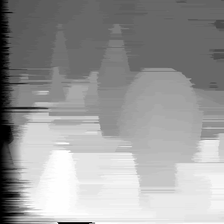

In [6]:
max_value = max(max(final_img))
Image.fromarray(np.uint8((np.array(final_img)/max_value)*254)).resize((224,224), Image.ANTIALIAS)